# 📘 Title: ECG Signal Classification using 1D CNN

"""
This notebook classifies ECG signals as **normal** or **abnormal** using a 1D Convolutional Neural Network.
It includes:
- Data loading and preprocessing
- Visualization
- Model construction and training
- Evaluation and performance metrics
"""


# 🔽 1. Importing Libraries


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
from tensorflow.keras import layers, models, callbacks
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


# 📂 2. Data Loading and Labeling

"""
Two ECG datasets are loaded:
- `normal.csv` for normal ECG samples
- `abnormal.csv` for abnormal ECG samples

A binary label is assigned to each:  
`0 = normal`, `1 = abnormal`
"""


In [41]:
def load_data():
    normal = pd.read_csv("/kaggle/input/heartbeat/ptbdb_normal.csv", header=None)
    abnormal = pd.read_csv("/kaggle/input/heartbeat/ptbdb_abnormal.csv", header=None)
    
    mitbih_train = pd.read_csv("/kaggle/input/heartbeat/mitbih_train.csv", header=None)
    mitbih_test = pd.read_csv("/kaggle/input/heartbeat/mitbih_test.csv", header=None)
    
    return normal, abnormal, mitbih_train, mitbih_test

normal, abnormal, mitbih_train, mitbih_test = load_data()


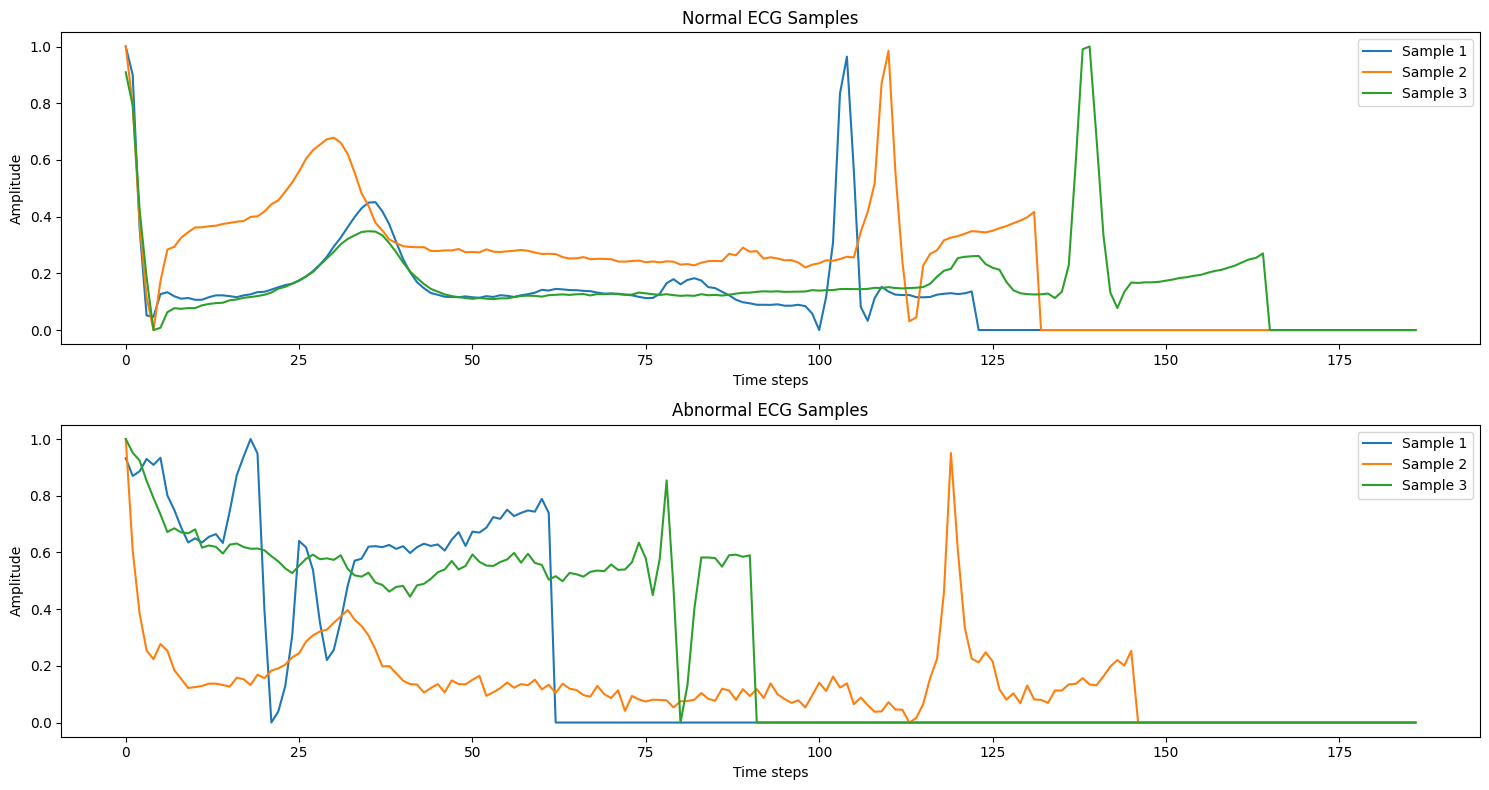

In [42]:
def plot_sample_ecgs(normal, abnormal, num_samples=3):
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    for i in range(num_samples):
        plt.plot(normal.iloc[i, :-1], label=f'Sample {i+1}')
    plt.title('Normal ECG Samples')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    for i in range(num_samples):
        plt.plot(abnormal.iloc[i, :-1], label=f'Sample {i+1}')
    plt.title('Abnormal ECG Samples')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_sample_ecgs(normal, abnormal)

# ⚖️ 3. Data Balancing and Splitting

"""
The function `load_and_balance_data`:
- Concatenates the two datasets
- Labels the samples
- Normalizes ECG signals
- Shuffles the data
- Splits it into:
    - 80% training
    - 10% validation
    - 10% testing
- Computes class weights for training
"""


In [43]:
def load_and_balance_data(normal_path, abnormal_path, train_size=0.8, val_test_split=0.5, random_state=42):
    """
    Load and balance ECG data with train/val/test splits (80/10/10)
    
    Args:
        normal_path: Path to normal ECG data
        abnormal_path: Path to abnormal ECG data
        train_size: Ratio of data for training (default 0.8)
        val_test_split: Ratio of remaining data to allocate to validation (default 0.5)
        random_state: Random seed for reproducibility
        
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test, class_weights
    """
    normal = pd.read_csv(normal_path, header=None)
    abnormal = pd.read_csv(abnormal_path, header=None)
    
    normal['label'] = 0
    abnormal['label'] = 1
    
    data = pd.concat([normal, abnormal], axis=0)
    data = data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    class_counts = np.bincount(y)
    total_samples = len(y)
    class_weights = {
        0: total_samples / (2 * class_counts[0]),  # Normal
        1: total_samples / (2 * class_counts[1])   # Abnormal
    }
    
    # First split: train vs (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        train_size=train_size, 
        random_state=random_state, 
        stratify=y
    )
    
    # Second split: val vs test from remaining data
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=val_test_split,  
        random_state=random_state,
        stratify=y_temp
    )
    
    print(f"Total samples: {len(X)}")
    print(f"Train samples: {len(X_train)} ({len(X_train)/len(X):.1%})")
    print(f"Validation samples: {len(X_val)} ({len(X_val)/len(X):.1%})")
    print(f"Test samples: {len(X_test)} ({len(X_test)/len(X):.1%})")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, class_weights

X_train, X_val, X_test, y_train, y_val, y_test, class_weights = load_and_balance_data(
    "/kaggle/input/heartbeat/ptbdb_normal.csv",
    "/kaggle/input/heartbeat/ptbdb_abnormal.csv"
)


Total samples: 14552
Train samples: 11641 (80.0%)
Validation samples: 1455 (10.0%)
Test samples: 1456 (10.0%)


# 📊 4. Data Distribution Visualization

"""
Class distribution is visualized to understand:
- Class balance in training, validation, and test sets
- Effectiveness of the split
"""


In [44]:
print(f"Class weights: {class_weights}")
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Class weights: {0: 1.7983193277310925, 1: 0.6925566343042071}
Train shapes: X=(11641, 188, 1), y=(11641,)
Test shapes: X=(1456, 188, 1), y=(1456,)


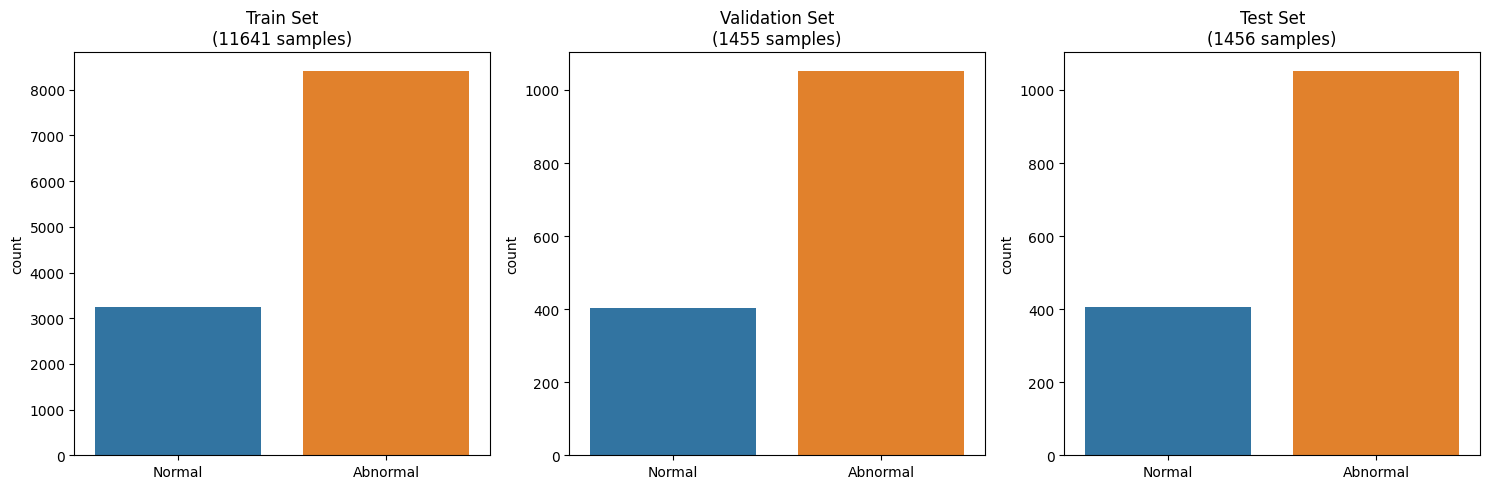

In [45]:
def plot_class_distribution(y_train, y_val, y_test):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    sns.countplot(x=y_train, ax=ax[0])
    ax[0].set_title(f'Train Set\n({len(y_train)} samples)')
    ax[0].set_xticklabels(['Normal', 'Abnormal'])
    
    sns.countplot(x=y_val, ax=ax[1])
    ax[1].set_title(f'Validation Set\n({len(y_val)} samples)')
    ax[1].set_xticklabels(['Normal', 'Abnormal'])
    
    sns.countplot(x=y_test, ax=ax[2])
    ax[2].set_title(f'Test Set\n({len(y_test)} samples)')
    ax[2].set_xticklabels(['Normal', 'Abnormal'])
    
    plt.tight_layout()
    plt.show()

plot_class_distribution(y_train, y_val, y_test)

# 🧠 6. Model Architecture

"""
A 1D Convolutional Neural Network is constructed using:
- Multiple Conv1D layers
- Dropout for regularization
- MaxPooling for downsampling
- Dense layers with sigmoid activation for binary output

The model is compiled with:
- Binary Crossentropy loss
- Adam optimizer
- Accuracy as evaluation metric
"""


In [46]:
from tensorflow.keras import regularizers

In [47]:
def build_model(input_shape):
    model = models.Sequential([
        # First Conv Block
        layers.Conv1D(64, kernel_size=15, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.4),
        
        # Second Conv Block
        layers.Conv1D(128, kernel_size=11, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.4),
                # Third Conv Block
        layers.Conv1D(256, kernel_size=7, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.4),

        layers.GlobalAveragePooling1D(),
        
        layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [48]:
X_train.shape[1]

188

In [49]:
X_train.shape[2]

1

In [50]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 174, 64)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 174, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 87, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 87, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 77, 128)             │          90,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 77, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 32, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 32, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,225 (1.36 MB)

 Trainable params: 355,073 (1.35 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [51]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_auc',  
    patience=15,
    mode='max',
    restore_best_weights=True)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_auc',
    save_best_only=True,
    mode='max')

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6)

# 🏋️‍♂️ 7. Model Compilation and Training

"""
Model is trained using `model.fit` with:
- Training data
- Validation split
- Class weights to handle data imbalance


In [52]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  
    batch_size=128,
    class_weight=class_weights,  
    callbacks=[early_stopping, model_checkpoint, reduce_lr],shuffle=True)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.6390 - auc: 0.7322 - loss: 1.0824 - precision: 0.8646 - recall: 0.5940 - val_accuracy: 0.7223 - val_auc: 0.5684 - val_loss: 0.9949 - val_precision: 0.7223 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8153 - auc: 0.9086 - loss: 0.7716 - precision: 0.9394 - recall: 0.7950 - val_accuracy: 0.7223 - val_auc: 0.5629 - val_loss: 1.0923 - val_precision: 0.7223 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8532 - auc: 0.9328 - loss: 0.6718 - precision: 0.9463 - recall: 0.8453 - val_accuracy: 0.7223 - val_auc: 0.5213 - val_loss: 1.3945 - val_precision: 0.7223 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8839 - auc: 0.9521 - loss: 0.5814 - precision: 0.9529 - recall: 0.8824 - val_accuracy: 0.7223 - val_auc: 0.5756 - val_loss: 1.7439 - val_p

# 📉 8. Training History

"""
Loss and accuracy curves for both training and validation sets are plotted
to visualize learning progress and detect overfitting.
"""


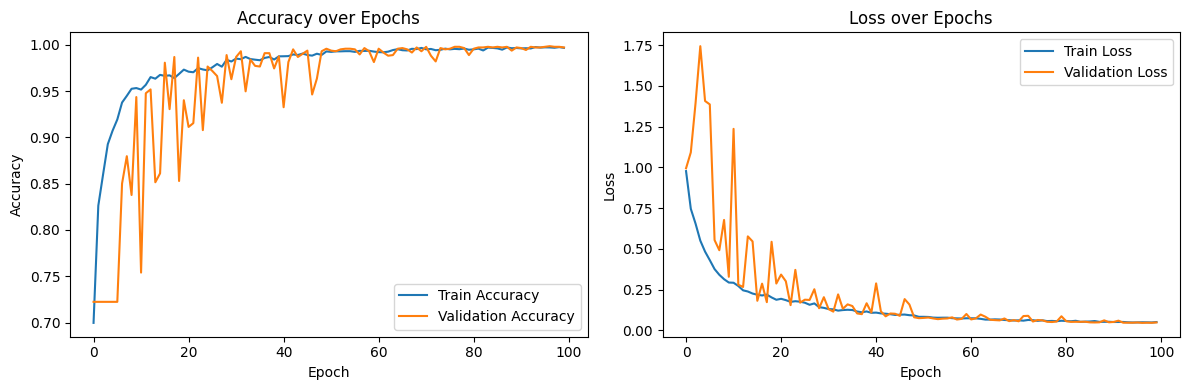

In [53]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)


Evaluating model on test set...
Test Loss: 0.0510
Test Accuracy: 0.9959
Test AUC: 0.9981
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       405
    Abnormal       1.00      1.00      1.00      1051

    accuracy                           1.00      1456
   macro avg       0.99      1.00      0.99      1456
weighted avg       1.00      1.00      1.00      1456



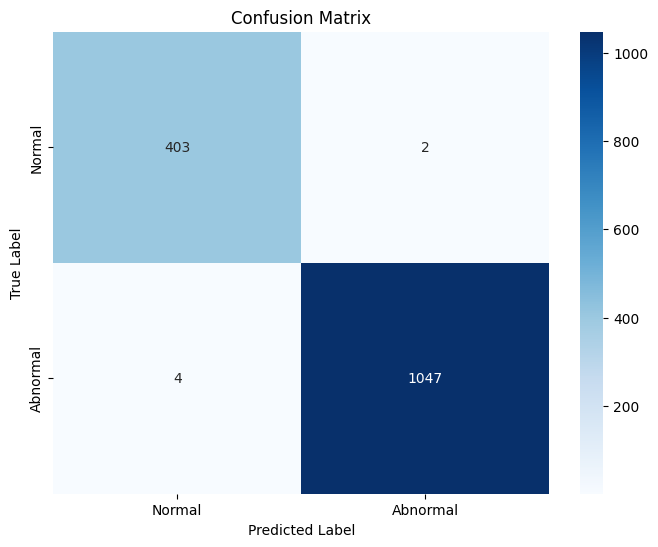

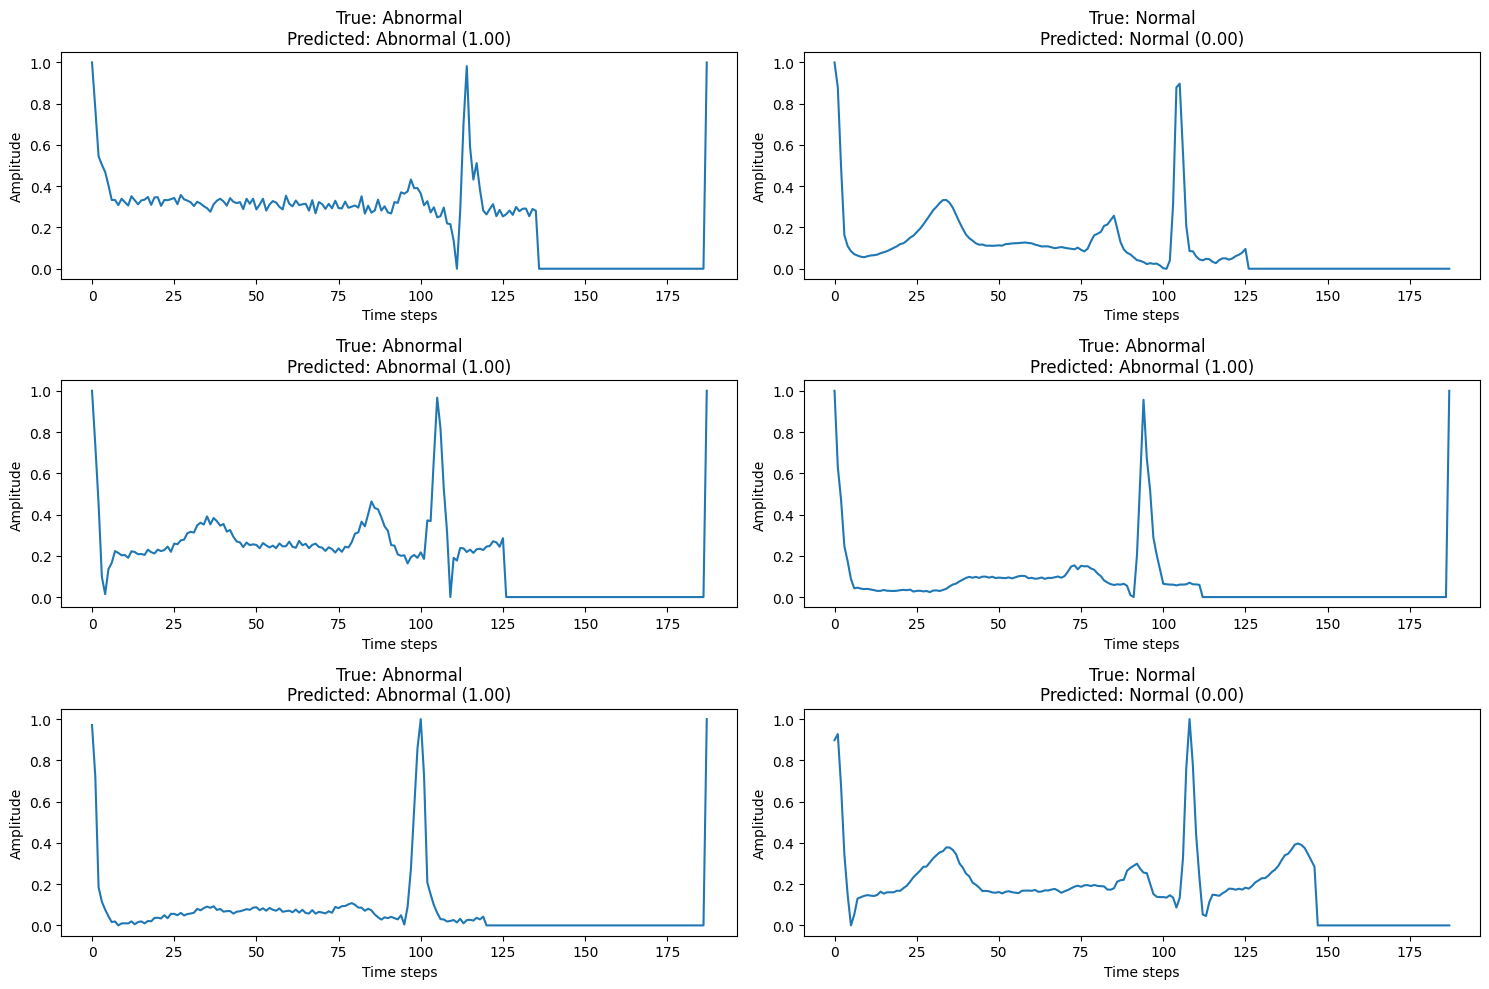

In [54]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_and_plot(model, X_test, y_test):
    # 1. Model Evaluation
    print("\nEvaluating model on test set...")
    test_results = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    
    # 2. Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    # 3. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, 
                              target_names=['Normal', 'Abnormal']))
    
    # 4. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Abnormal'],
                yticklabels=['Normal', 'Abnormal'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    plt.figure(figsize=(15, 10))
    for i in range(6):
        idx = np.random.randint(0, len(X_test))
        ecg = X_test[idx].flatten()
        true_label = y_test[idx]
        pred_prob = y_pred[idx][0]
        
        plt.subplot(3, 2, i+1)
        plt.plot(ecg)
        plt.title(f"True: {'Abnormal' if true_label else 'Normal'}\n"
                 f"Predicted: {'Abnormal' if pred_prob > 0.5 else 'Normal'} "
                 f"({pred_prob:.2f})")
        plt.xlabel('Time steps')
        plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

evaluate_and_plot(model, X_test, y_test)

In [55]:
model.save('ecg_model.h5')  

In [56]:
from tensorflow.keras.models import load_model
model = load_model('best_model.keras') 
model.summary()
sample_input = X_test[0:1]  
prediction = model.predict(sample_input)
print(f"Prediction: {'Abnormal' if prediction > 0.5 else 'Normal'} ({prediction[0][0]:.2f})")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 174, 64)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 174, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 87, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 87, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 77, 128)             │          90,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 77, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 32, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 32, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,066,373 (4.07 MB)

 Trainable params: 355,073 (1.35 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 710,148 (2.71 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Prediction: Abnormal (1.00)


# ✅ 9. Final Evaluation

"""
The trained model is evaluated on the test set using:
- Accuracy
- Confusion Matrix
- Classification Report

This step quantifies how well the model generalizes to unseen ECG data.
"""



Evaluating model on test set...
Test Loss: 0.0510
Test Accuracy: 0.9959
Test AUC: 0.9981
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       405
    Abnormal       1.00      1.00      1.00      1051

    accuracy                           1.00      1456
   macro avg       0.99      1.00      0.99      1456
weighted avg       1.00      1.00      1.00      1456



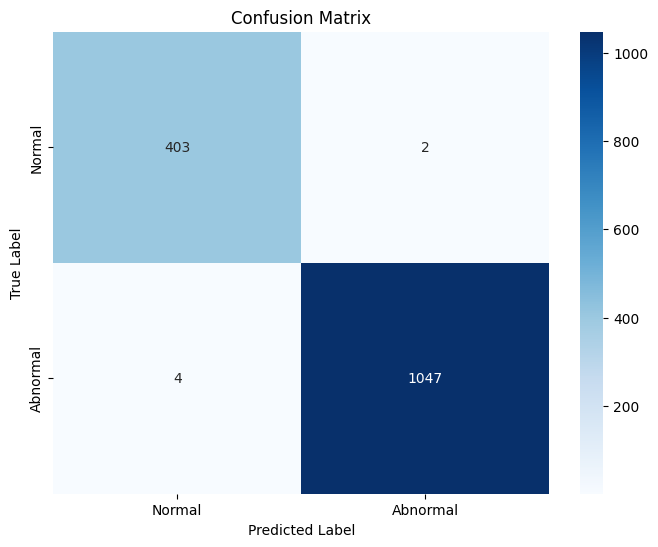

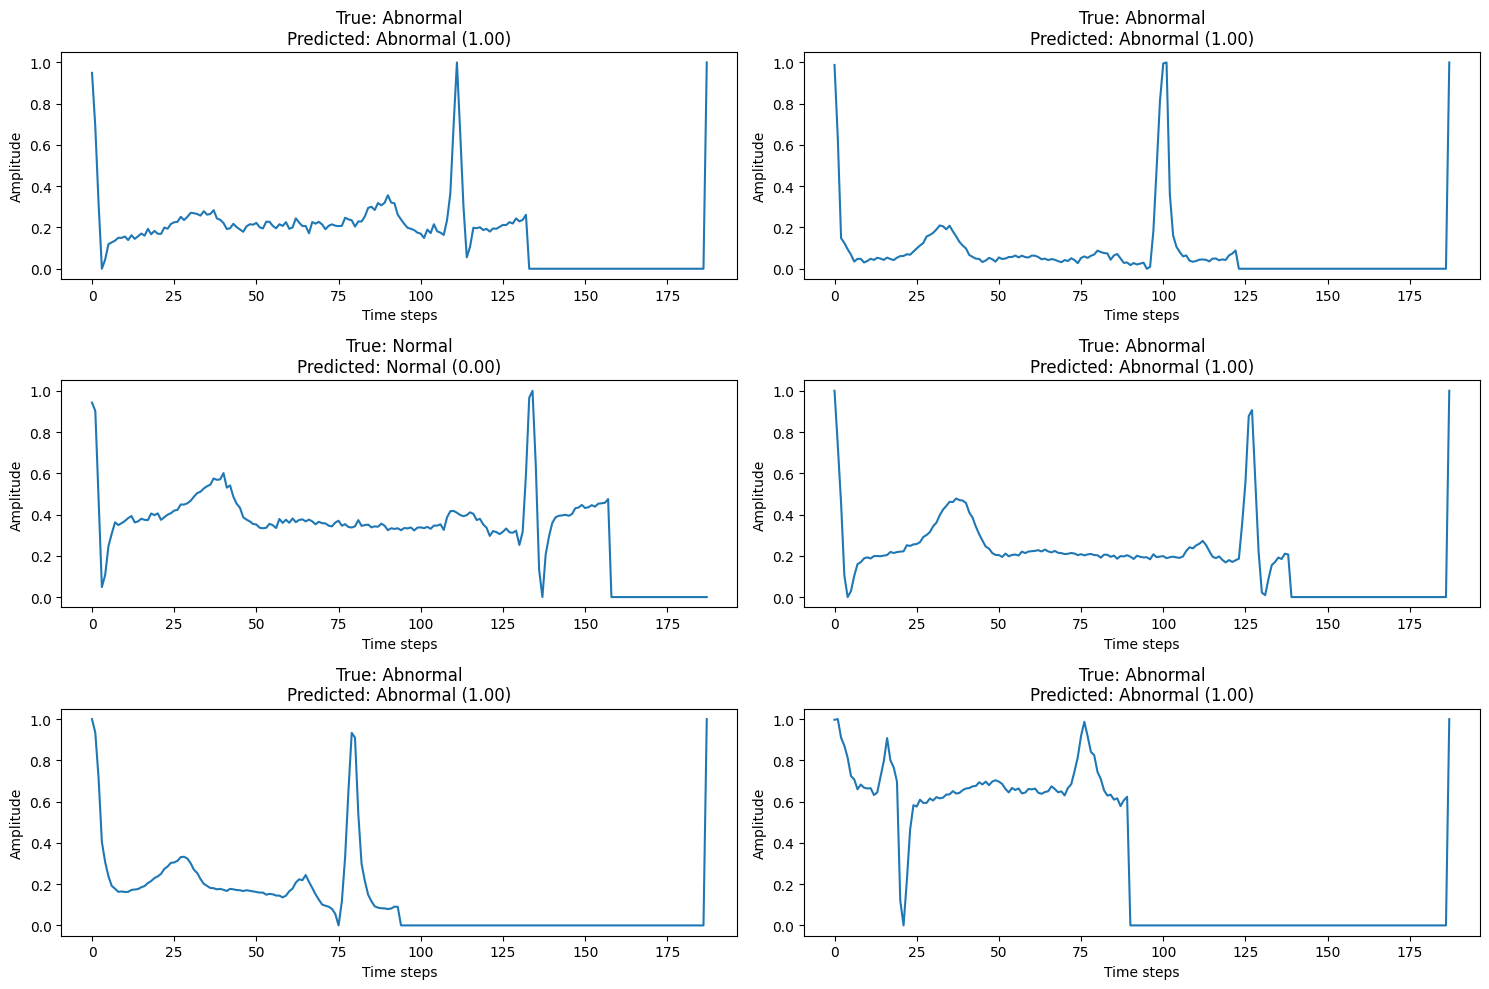

In [57]:
evaluate_and_plot(model, X_test, y_test)

In [58]:
from tensorflow.keras.models import load_model
model = load_model('ecg_model.h5') 
model.summary()
sample_input = X_test[0:1]  
prediction = model.predict(sample_input)
print(f"Prediction: {'Abnormal' if prediction > 0.5 else 'Normal'} ({prediction[0][0]:.2f})")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 174, 64)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 174, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 87, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 87, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 77, 128)             │          90,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 77, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 32, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 32, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,227 (1.36 MB)

 Trainable params: 355,073 (1.35 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Prediction: Abnormal (1.00)



Evaluating model on test set...
Test Loss: 0.0510
Test Accuracy: 0.9959
Test AUC: 0.9981
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       405
    Abnormal       1.00      1.00      1.00      1051

    accuracy                           1.00      1456
   macro avg       0.99      1.00      0.99      1456
weighted avg       1.00      1.00      1.00      1456



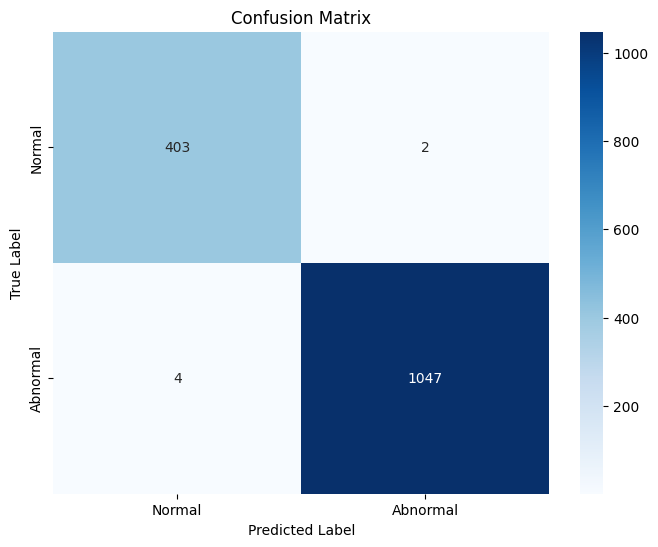

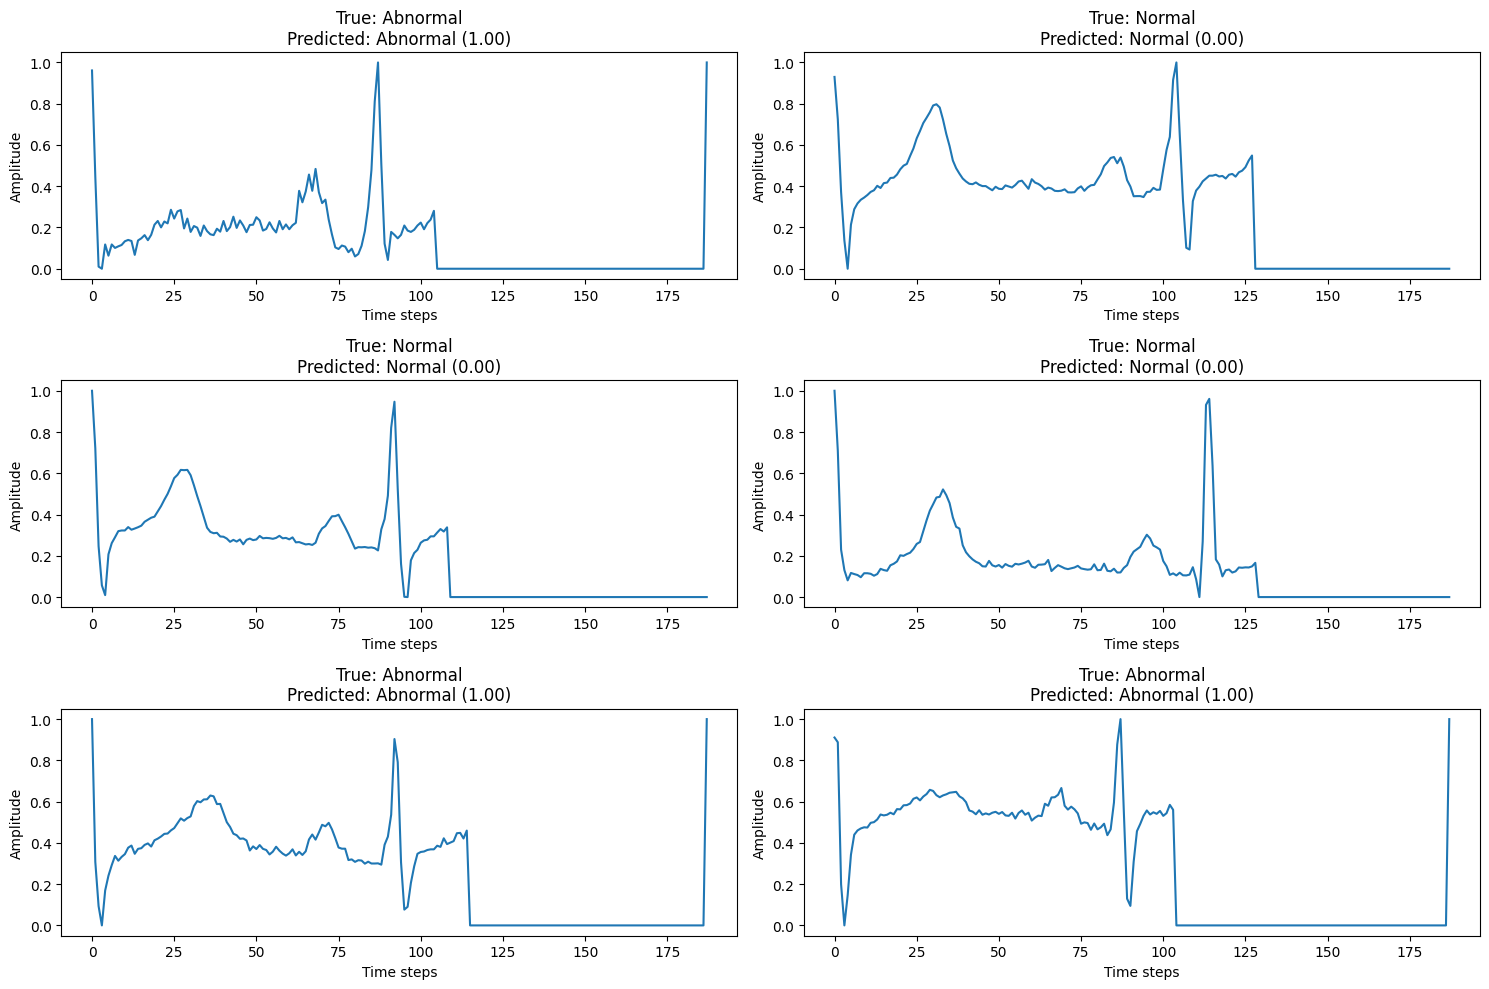

In [59]:
evaluate_and_plot(model, X_test, y_test)

## 🧪 Hints for Deployment

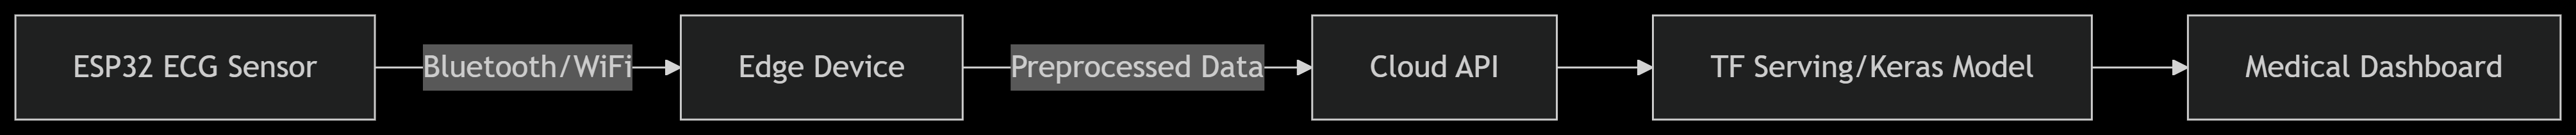
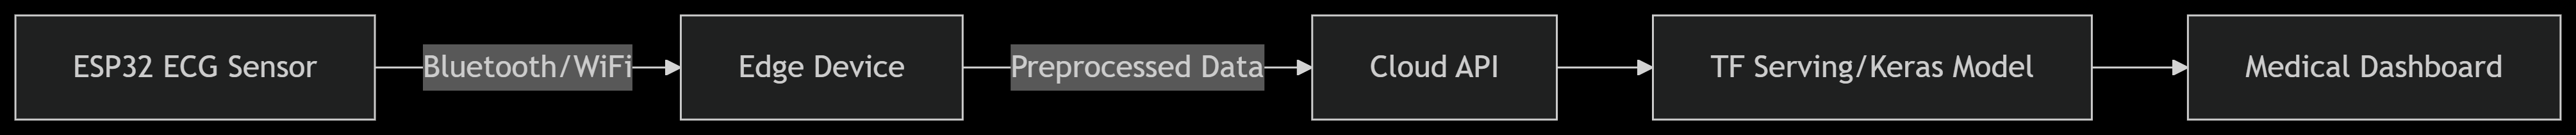

## ⚡ Input Specifications

| **Parameter**       | **Value**                        |
|---------------------|----------------------------------|
| Input Shape         | (1, 188, 1)                      |
| Sampling Rate       | 250 Hz                           |
| Signal Length       | 188 samples (~0.75s)             |
| Voltage Range       | ±2mV                             |
| Normalization       | Zero-mean, unit variance         |

---

## 🚀 Key Considerations for Real-Time Deployment

1. The **ESP32 must maintain a consistent 250Hz sampling rate** to match model expectations.
2. Always implement **signal quality checks** (e.g., baseline drift, noise) before inference.
3. Use a **circular buffer** to manage real-time ECG signal windows (e.g., 188 samples).
4. **Quantized models** (e.g., via TensorFlow Lite) can reduce **power consumption by ~4x**, making them ideal for embedded inference.

---
